# Result analysis
- Do inference
- Try to visualize the knowledge after learning from data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import random
import numpy as np
import pprint
from time import gmtime, strftime
import glob
import torch
import torch.nn as nn
# from torch.backends import cudnn

from Logging import Logger
# from config import cfg
from model import MnistModel
from evaluator import Evaluator
from pgd_attack import LinfPGDAttack
from utils import *

In [2]:
from types import SimpleNamespace


cfg = SimpleNamespace(
    seed=0,
    randomize=False,
    log_dir='logs',
    exp_name='debug',
    no_log=False,
    data_dir='data/mnist',
    batch_size=200,
    eval_batch_size=200,
    eval_model="snapshots/debug/checkpoint_100.pth",
    epsilon=0.3,
    k=40,
    alpha=0.01,
    random_start=False,
)

In [3]:
import random
# cudnn.benchmark = True
# os.environ["CUDA_VISIBLE_DEVICES"] = cfg.gpus
if not cfg.randomize:
    # set fixed seed
    random.seed(cfg.seed)
    np.random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    torch.cuda.manual_seed(cfg.seed)
    
log_path = os.path.join(cfg.log_dir, cfg.exp_name)
mkdir_if_missing(log_path)

# if not cfg.no_log:
#     log_name = cfg.exp_name + "_eval_log_" + \
#             strftime("%Y-%m-%d_%H-%M-%S", gmtime()) + '.txt'
#     sys.stdout = Logger(os.path.join(log_path, log_name))

In [4]:
print("Input Args: ")
pprint.pprint(cfg)

Input Args: 
namespace(seed=0,
          randomize=False,
          log_dir='logs',
          exp_name='debug',
          no_log=False,
          data_dir='data/mnist',
          batch_size=200,
          eval_batch_size=200,
          eval_model='snapshots/debug/checkpoint_100.pth',
          epsilon=0.3,
          k=40,
          alpha=0.01,
          random_start=False)


In [5]:
train_loader, test_loader, num_class, img_size = get_data_loader(
    data_dir=cfg.data_dir, 
    batch_size=cfg.batch_size, 
    test_batch_size=cfg.eval_batch_size, 
    num_workers=4
)
print("Num classes: ", num_class)
print("Img size: ", img_size)
print("Num train batches: ", len(train_loader))
print("Num test batches: ", len(test_loader))

Num classes:  10
Img size:  28
Num train batches:  300
Num test batches:  50


In [6]:
model = MnistModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

is_cuda = False
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
if torch.cuda.is_available():
    model = model.cuda()
    is_cuda = True

In [7]:
if cfg.eval_model is None:
    print('evaluate model is not specified')
    snapshots = []
elif os.path.isdir(cfg.eval_model):
    snapshots = glob.glob(os.path.join(cfg.eval_model, '*.pth'))
    snapshots = sorted(snapshots, key=lambda x: 
        int(os.path.basename(x).split('_')[1].split('.')[0]))
elif os.path.isfile(cfg.eval_model):
    snapshots = [cfg.eval_model]
else:
    snapshots = []

In [10]:
def load_model2(model, path):
    if not os.path.isfile(path):
        raise IOError('model: {} is non-exists'.format(path))
    if hasattr(model, 'module'):
        module = model.module
    else:
        module = model
    checkpoint = torch.load(path, map_location=device)
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    module.load_state_dict(state_dict, strict=False)
    print('Params Loaded from: {}'.format(path))

In [11]:
for snapshot in snapshots:
    load_model2(model, snapshot)
    attack = LinfPGDAttack(model=model, epsilon=cfg.epsilon, k=cfg.k, 
                        alpha=cfg.alpha, random_start=cfg.random_start)
    evaluator = Evaluator(model=model, attack=attack, is_cuda=is_cuda, verbose=False)
    acc, adv_acc = evaluator.evaluate(test_loader)
    print("natural     accuracy: {:.4f}".format(acc))
    print("adversarial accuracy: {:.4f}".format(adv_acc))

Params Loaded from: snapshots/debug/checkpoint_100.pth


KeyboardInterrupt: 

## Inference

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch

def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        image = images[i, ...]
        image = image.cpu().numpy().transpose((1, 2, 0))
        image += noise
        image = np.clip(image, 0.0, 1.0)
        ax.imshow(image)
        
        cls_true_name = str(cls_true[i].cpu().numpy())
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            cls_pred_name = str(cls_pred[i].cpu().numpy())
            xlabel = "True: {0}, Pred: {1}".format(cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

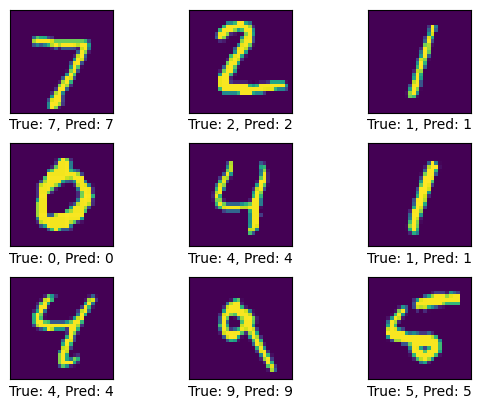

In [37]:
from sympy import false


attack = LinfPGDAttack(model=model, epsilon=cfg.epsilon, k=cfg.k, 
                        alpha=cfg.alpha, random_start=cfg.random_start)

false_neu_ids = []
false_adv_ids = []

n_sample = 200
n_select = 9

for batch in test_loader:
    x, y = batch
    x, y = x.to(device), y.to(device)
    x, y = x[:n_sample], y[:n_sample]

    pred = model(x)
    pred = pred.argmax(dim=1)
    
    false_neu_ids = torch.where(pred != y)[0]
    
    x_adv = attack(x, y)
    pred_adv = model(x_adv)
    pred_adv = pred_adv.argmax(dim=1)
    
    false_adv_ids = torch.where(pred_adv != y)[0]
    
    break

plot_images(x[:9], y[:9], pred[:9], noise=0.0)


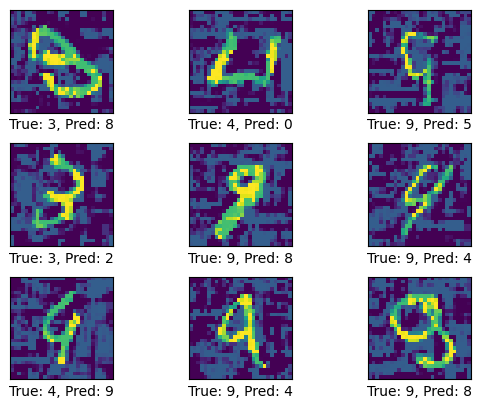

In [49]:
if len(false_adv_ids) > 0:
    plot_images(x_adv[false_adv_ids[:9]], y[false_adv_ids[:9]], pred_adv[false_adv_ids[:9]], noise=0.0)

### Feature

In [50]:
# get last layer output of the model
def get_last_layer_out(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu(x)

    # if self.has_dropout:
    #     x = self.dropout(x)

    # x = self.fc2(x)

    return x

In [69]:
embeddings_adv = []
embeddings_neu = []
labels = []

for idx, batch in enumerate(test_loader):
    x, y = batch
    x, y = x.to(device), y.to(device)
    x, y = x[:n_sample], y[:n_sample]
    
    x_adv = attack(x, y)
    
    embeddings_adv.append(get_last_layer_out(model, x_adv).detach().cpu().numpy())
    embeddings_neu.append(get_last_layer_out(model, x).detach().cpu().numpy())
    labels.append(y.detach().cpu().numpy())
    
    if idx == 10:
        break

embeddings_adv = np.concatenate(embeddings_adv, axis=0)
embeddings_neu = np.concatenate(embeddings_neu, axis=0)
labels = np.concatenate(labels, axis=0)

(2200, 2)


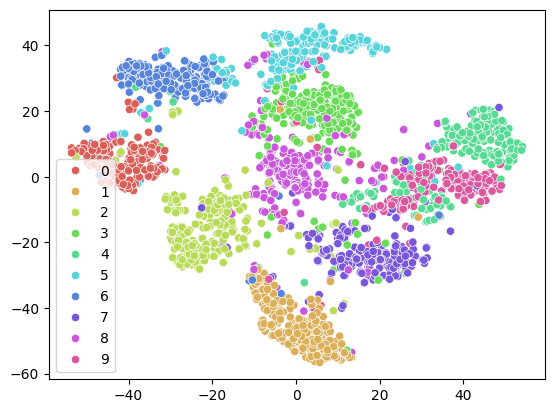

In [71]:
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_adv)

print(embeddings_2d.shape)

sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, legend='full', palette=sns.color_palette("hls", 10))
plt.show()


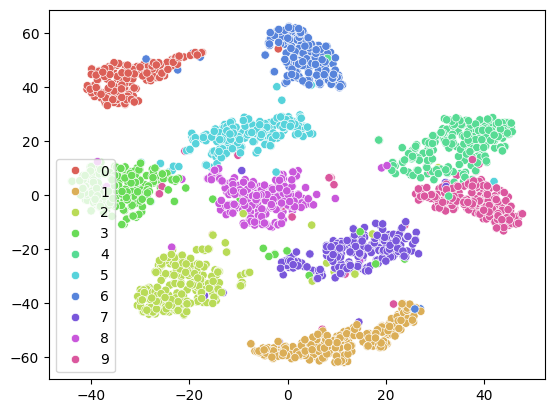

In [72]:
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_neu)


sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, legend='full', palette=sns.color_palette("hls", 10))
plt.show()


### Feature map

In [113]:
def get_feature_map(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)

    return x

In [114]:
for idx, batch in enumerate(test_loader):
    x, y = batch
    x, y = x.to(device), y.to(device)
    x, y = x[:n_sample], y[:n_sample]
    
    x_adv = attack(x, y)
    
    feature_map_adv = get_feature_map(model, x_adv)
    feature_map_neu = get_feature_map(model, x)
    
    break

In [92]:
# plot
def plot_feature_map(feature_map, n_sample=9):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        image = feature_map[i, ...]
        image = image.cpu().detach().numpy()[1, :, :].transpose((1, 2, 0))
        ax.imshow(image)
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [143]:
def plot_list_images(images, n_sample=9):
    fig, axes = plt.subplots(1, n_sample)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        image = images[i, ...]
        # image = image.cpu().detach().numpy().transpose((1, 2, 0))
        ax.imshow(image)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    # set width and height
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_sample * 1.5)
    plt.show()

n_sample=64
plot_list_images(feature_map_adv.detach()[8, ...].cpu().numpy()[:n_sample, :, :], n_sample=n_sample)

In [134]:
feature_map_adv.shape

torch.Size([10, 64, 7, 7])